In [16]:
import gymnasium as gym
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# GYMNASIUM FRAMEWORK : BlackJack

Let's explore a version of BlackJack where 
- there are two players only;
- the card dealer has a fixed policy.

## Basics of Gym.

In [4]:
# First make a new environment choising the desired game and a render_mode ('human' means there will be a pygame window displaying the game states)
env = gym.make('Blackjack-v1', render_mode = 'rgb_array')

# Before starting any episode, reset the env to create a new initial step
observation, info = env.reset()

observation

(10, 10, 0)

## First almost deterministic policy

In [27]:
file = "/Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/blackjack/log.txt"
fd = open(file, mode = 'w')

# The choice for the next action will follow Ber(0.95) with P[hit] = 0.95 and P[bust] = 0.05
probability_distribution = np.array([.05, .95], dtype = np.float64)

# Counter of episodes
max_episode = 100000
total_reward = np.zeros(shape = max_episode, dtype = np.float64)

fd.write(f"|{'PLAYER S CURRENT SUM':^30}|{'OPPONENT S CURRENT SUM':^30}|{'USABLE ACE?':^30}|\n")
for episode in tqdm(range(max_episode)):
    fd.write(f"|{'':-^30}|{'':-^30}|{'':-^30}|\n")
    
    observation, info = env.reset()
    current_sum, opponent_sum, available_ace = observation

    fd.write(f"|{current_sum:^30}|{opponent_sum:^30}|{available_ace:^30}|\n")

    episode_over = False
    
    while not episode_over:
        action = env.action_space.sample(probability = probability_distribution)
        fd.write(f"|{'HIT' if action > 0 else 'BUST':^30}|{'':^30}|{'':^30}|\n")

        observation, reward, terminated, truncated, info = env.step(action)
        
        current_sum, opponent_sum, available_ace = observation

        fd.write(f"|{current_sum:^30}|{opponent_sum:^30}|{available_ace:^30}|\n")

        total_reward[episode] += reward
        episode_over = terminated


    fd.write(f"|{'WON' if reward > 0 else 'LOOSE':^30}|{'WON' if reward < 0 else 'LOOSE':^30}|{'':^30}|\n")
    episode += 1

fd.write(f'{"":-^94}')
env.close()
fd.close()

100%|██████████| 100000/100000 [00:06<00:00, 15278.29it/s]


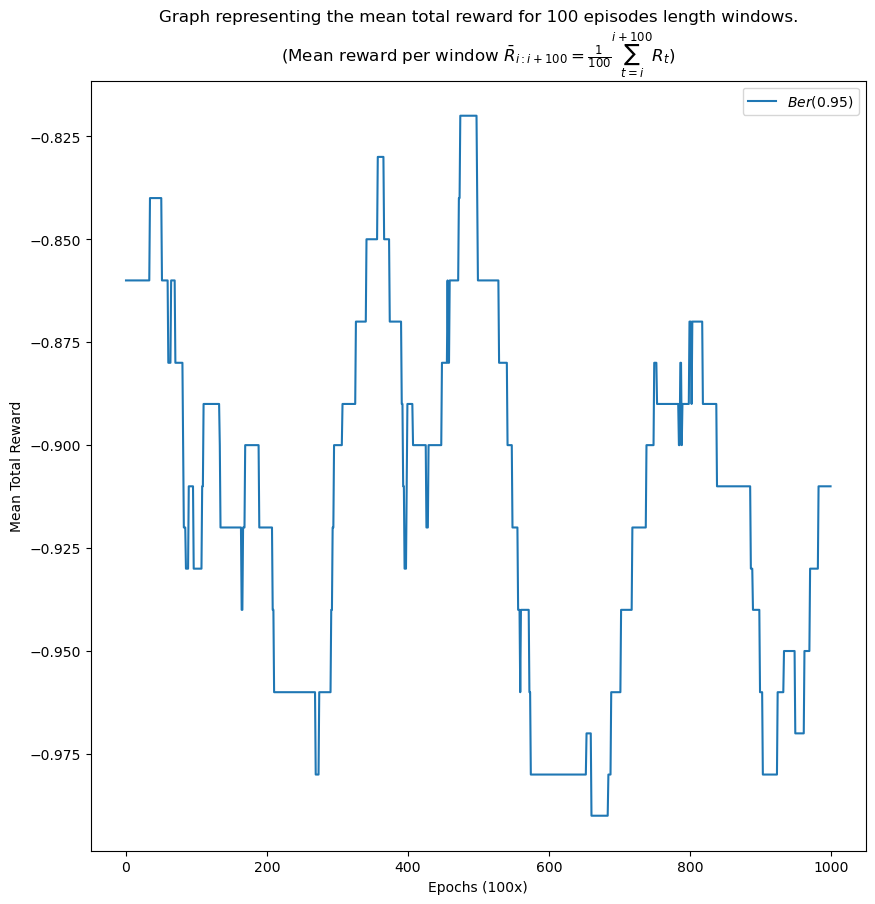

In [34]:
# Display the mean over the last 100 episodes
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

support = np.arange(0, max_episode // 100)
image = np.array([total_reward[i:i+100].mean() for i in support])

ax.set_xlabel("Epochs (100x)")
ax.set_ylabel("Mean Total Reward")
ax.set_title("Graph representing the mean total reward for 100 episodes length windows.\n" + r"(Mean reward per window $ \bar{R}_{i:i+100} = \frac{1}{100} \sum_{t = i}^{i + 100} R_t$)")

ax.plot(support, image, label = r"$Ber(0.95)$")

ax.legend()